## Forecasting the production of electricity using LSTM.

#### The dataset has the electricity production records from 01-10-2004 to 02-01-2018. 
#### Total no. of rows 121273

## Importing Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

from scipy.stats import gaussian_kde
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
from plotly.subplots import make_subplots

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Importing the dataset

In [9]:
df = pd.read_csv('AEP_hourly.csv')
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [10]:
df = df.sort_values(by='Datetime')
df

,Datetime,AEP_MW
2183,2004-10-01 01:00:00,12379.0
2184,2004-10-01 02:00:00,11935.0
2185,2004-10-01 03:00:00,11692.0
2186,2004-10-01 04:00:00,11597.0
2187,2004-10-01 05:00:00,11681.0
...,...,...
116157,2018-08-02 20:00:00,17673.0
116158,2018-08-02 21:00:00,17303.0
116159,2018-08-02 22:00:00,17001.0
116160,2018-08-02 23:00:00,15964.0


### Splitting the data into training and testing

In [ ]:
train_size = int(len(df)*0.8)

In [12]:
data_train = df[:train_size]
data_train.to_csv('AEP_hourly_train.csv',index=False)

In [13]:
data_test = df[train_size:]
data_test.to_csv('AEP_hourly_test.csv',index=False)

In [14]:
df_train = pd.read_csv('AEP_hourly_train.csv',parse_dates=['Datetime'])
df_train

,Datetime,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0
...,...,...
97013,2015-10-27 05:00:00,11779.0
97014,2015-10-27 06:00:00,12583.0
97015,2015-10-27 07:00:00,14032.0
97016,2015-10-27 08:00:00,14867.0


In [15]:
df_train = df_train[96018:]

In [16]:
from datetime import datetime

In [17]:
train_dataset = df_train

In [18]:
train_dataset.index = df_train['Datetime']
train_dataset

,Datetime,AEP_MW
Datetime,,
2015-09-15 18:00:00,2015-09-15 18:00:00,16437.0
2015-09-15 19:00:00,2015-09-15 19:00:00,16157.0
2015-09-15 20:00:00,2015-09-15 20:00:00,15781.0
2015-09-15 21:00:00,2015-09-15 21:00:00,15994.0
2015-09-15 22:00:00,2015-09-15 22:00:00,15220.0
...,...,...
2015-10-27 05:00:00,2015-10-27 05:00:00,11779.0
2015-10-27 06:00:00,2015-10-27 06:00:00,12583.0
2015-10-27 07:00:00,2015-10-27 07:00:00,14032.0


In [19]:
train_dataset = train_dataset.drop('Datetime', axis=1)
train_dataset

,AEP_MW
Datetime,
2015-09-15 18:00:00,16437.0
2015-09-15 19:00:00,16157.0
2015-09-15 20:00:00,15781.0
2015-09-15 21:00:00,15994.0
2015-09-15 22:00:00,15220.0
...,...
2015-10-27 05:00:00,11779.0
2015-10-27 06:00:00,12583.0
2015-10-27 07:00:00,14032.0


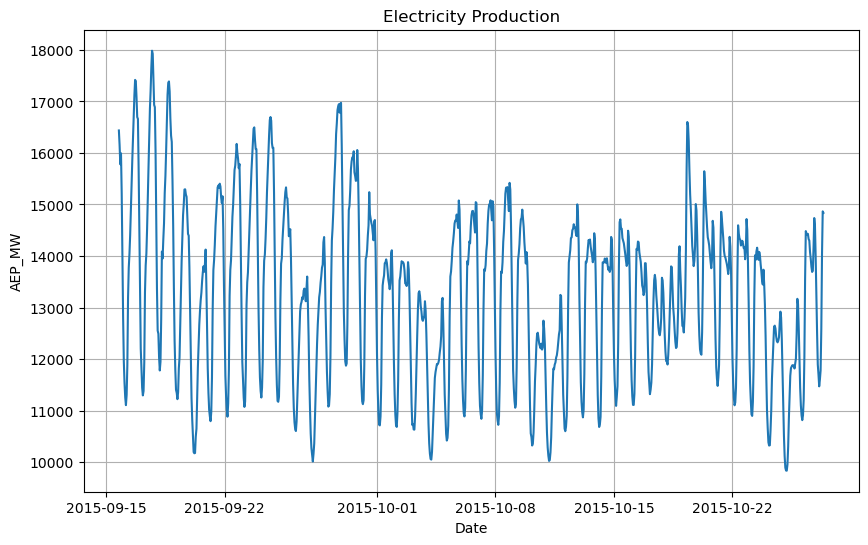

In [20]:
plt.figure(figsize = (10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.plot(train_dataset['AEP_MW'])
plt.title('Electricity Production')
plt.show()

<AxesSubplot:ylabel='Density'>

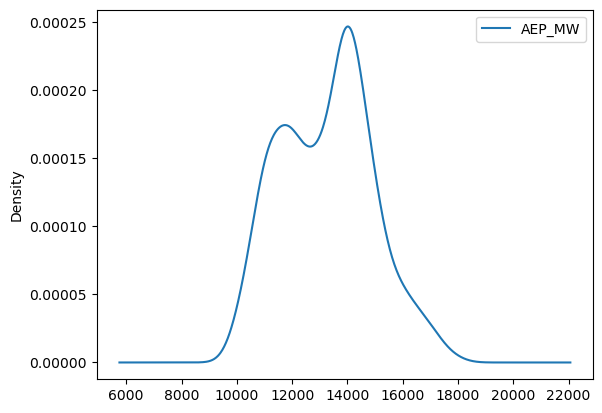

In [21]:
train_dataset.plot(kind='kde')

## Checking whether the data is stationary or not

In [22]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)


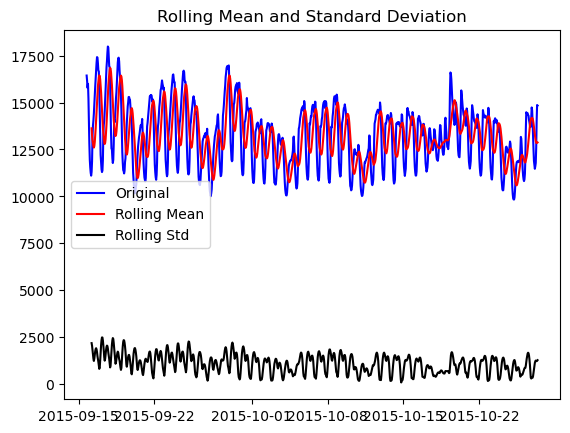

Results of dickey fuller test
Test Statistics                 -2.338454
p-value                          0.159866
No. of lags used                22.000000
Number of observations used    977.000000
critical value (1%)             -3.437061
critical value (5%)             -2.864503
critical value (10%)            -2.568348
dtype: float64


In [23]:
test_stationarity(train_dataset)

As the p-value is greater than 0.05 the data is not stationary

<Figure size 640x480 with 0 Axes>

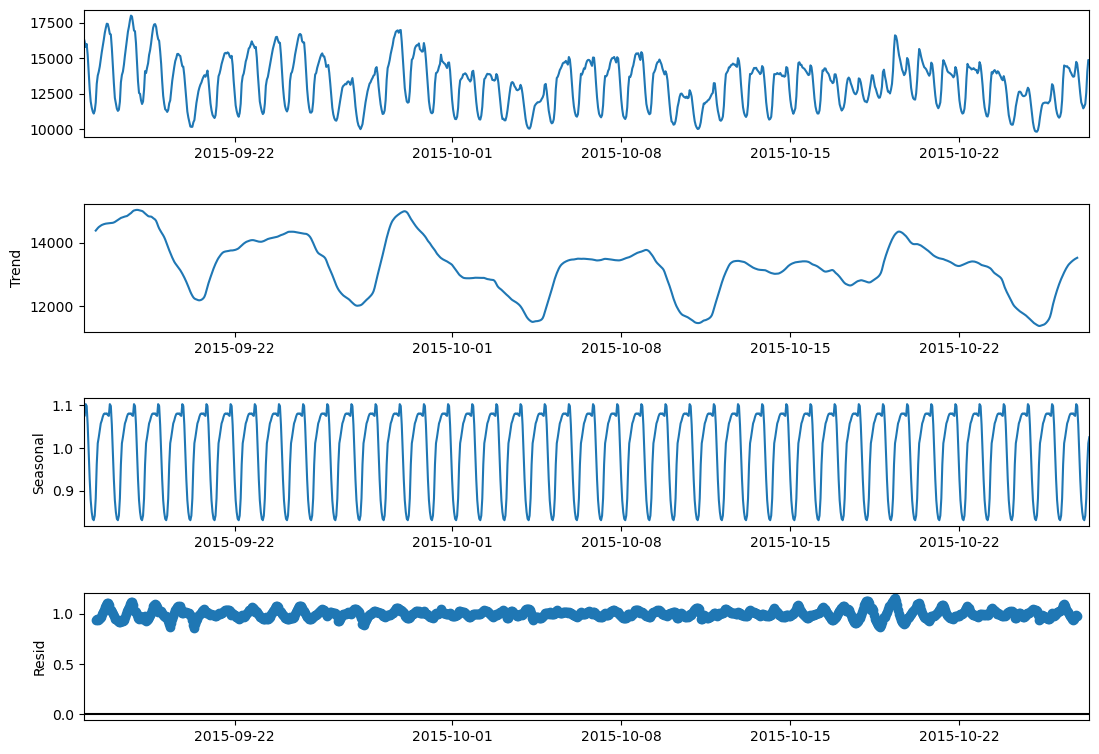

In [24]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(train_dataset[:2000], model='multiplicative', period = 24)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 8)

In [25]:
# The P-value < 0.05
# The Test value(-1.455077e+01) > critical value 5%(-2.861570e+00)

Plotting the ACF and PACF graph

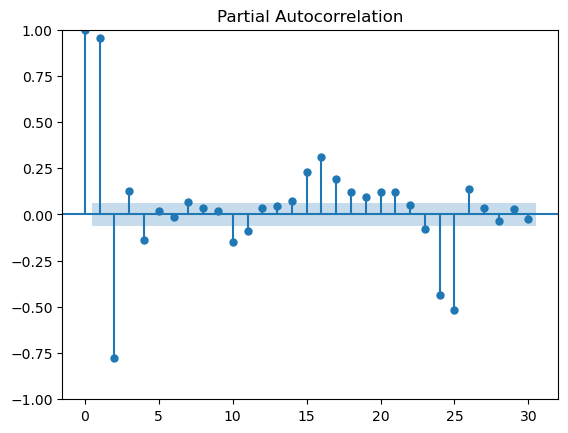

In [26]:
plot_pacf(train_dataset)
plt.show()

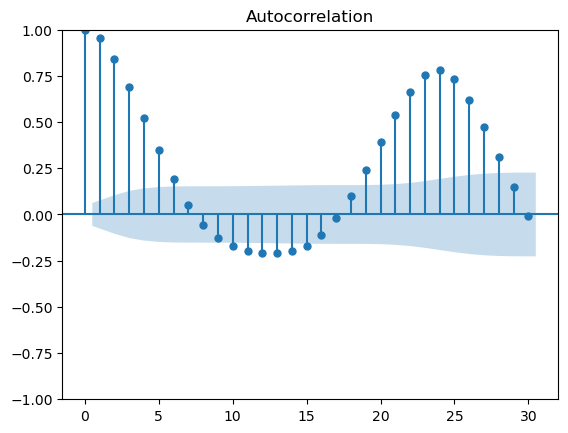

In [27]:
plot_acf(train_dataset)
plt.show()

## Hyperparameter Tuning (Auto-Arima)

In [28]:
model_autoarima = auto_arima(train_dataset, start_p = 0, start_q=0,
                            test = 'adf',
                            max_p=3, max_q=3,
                            m=12,
                            d = None,
                            seasonal = True,
                            start_P = 0,
                            D = 0,
                            trace = True,
                            error_action = 'ignore',
                            suppress_warnings = True,
                            stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=17674.323, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=17690.052, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=15216.920, Time=0.76 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16429.384, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=21839.009, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=15238.050, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=15234.849, Time=0.75 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=15231.799, Time=0.20 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=13727.760, Time=3.63 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=13714.543, Time=3.08 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=14326.159, Time=3.58 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=16994.601, Time=2.95 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(1,0,1)(2,0

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 1000
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -6575.749
Date:                                 Mon, 05 Aug 2024   AIC                          13167.498
Time:                                         13:05:13   BIC                          13206.760
Sample:                                     09-15-2015   HQIC                         13182.420
                                          - 10-27-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     37.2030     12.574      2.959      0.003      12.559      61

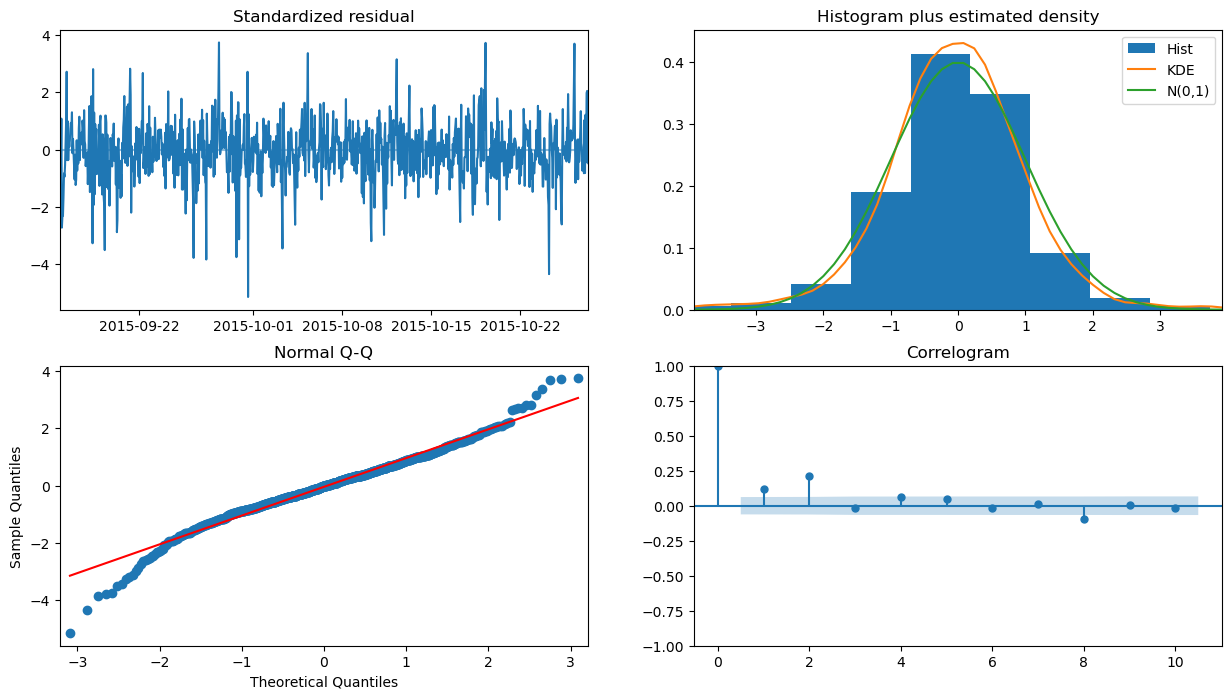

In [29]:
print(model_autoarima.summary())
model_autoarima.plot_diagnostics(figsize=(15,8))
plt.show()

In [30]:
model_autoarima.fit(train_dataset)

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

### Forecasting 

In [31]:
future_forecast = model_autoarima.predict(n_periods=60)

In [32]:
future_forecast

2015-10-27 10:00:00    14852.307579
2015-10-27 11:00:00    14866.079033
2015-10-27 12:00:00    14773.924240
2015-10-27 13:00:00    14697.056830
2015-10-27 14:00:00    14567.523750
2015-10-27 15:00:00    14445.470964
2015-10-27 16:00:00    14301.287979
2015-10-27 17:00:00    14217.186038
2015-10-27 18:00:00    14169.128336
2015-10-27 19:00:00    14423.484278
2015-10-27 20:00:00    14864.123730
2015-10-27 21:00:00    14683.025832
2015-10-27 22:00:00    14166.260788
2015-10-27 23:00:00    13497.090500
2015-10-28 00:00:00    12830.520349
2015-10-28 01:00:00    12311.473050
2015-10-28 02:00:00    12044.723401
2015-10-28 03:00:00    11840.613222
2015-10-28 04:00:00    11873.233955
2015-10-28 05:00:00    12018.180231
2015-10-28 06:00:00    12606.757302
2015-10-28 07:00:00    13678.234725
2015-10-28 08:00:00    14366.040564
2015-10-28 09:00:00    14408.337384
2015-10-28 10:00:00    14482.608642
2015-10-28 11:00:00    14528.606144
2015-10-28 12:00:00    14470.769837
2015-10-28 13:00:00    14423

In [33]:
df_test = pd.read_csv('AEP_hourly_test.csv')
#df_test.index = df_test['Datetime']
#df_test = df_test.drop('Datetime', axis=1)
df_test

,Datetime,AEP_MW
0,2015-10-27 10:00:00,15147.0
1,2015-10-27 11:00:00,14796.0
2,2015-10-27 12:00:00,14718.0
3,2015-10-27 13:00:00,14689.0
4,2015-10-27 14:00:00,14609.0
...,...,...
24250,2018-08-02 20:00:00,17673.0
24251,2018-08-02 21:00:00,17303.0
24252,2018-08-02 22:00:00,17001.0
24253,2018-08-02 23:00:00,15964.0


In [34]:
df_test.index = df_test['Datetime']

In [35]:
df_test = df_test.drop('Datetime', axis=1)
df_test

,AEP_MW
Datetime,
2015-10-27 10:00:00,15147.0
2015-10-27 11:00:00,14796.0
2015-10-27 12:00:00,14718.0
2015-10-27 13:00:00,14689.0
2015-10-27 14:00:00,14609.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [36]:
comp_table = df_test[:60]
comp_table

,AEP_MW
Datetime,
2015-10-27 10:00:00,15147.0
2015-10-27 11:00:00,14796.0
2015-10-27 12:00:00,14718.0
2015-10-27 13:00:00,14689.0
2015-10-27 14:00:00,14609.0
2015-10-27 15:00:00,14459.0
2015-10-27 16:00:00,14366.0
2015-10-27 17:00:00,14365.0
2015-10-27 18:00:00,14596.0


In [37]:
predict = pd.DataFrame(future_forecast)
predict.columns = ['prediction']
predict

,prediction
2015-10-27 10:00:00,14852.307579
2015-10-27 11:00:00,14866.079033
2015-10-27 12:00:00,14773.924240
2015-10-27 13:00:00,14697.056830
2015-10-27 14:00:00,14567.523750
2015-10-27 15:00:00,14445.470964
2015-10-27 16:00:00,14301.287979
2015-10-27 17:00:00,14217.186038
2015-10-27 18:00:00,14169.128336
2015-10-27 19:00:00,14423.484278


### Comparing the actual and predicted values

In [38]:
comp_table['prediction'] = predict['prediction']
comp_table['difference'] = comp_table['prediction']-comp_table['AEP_MW']
comp_table

,AEP_MW,prediction,difference
Datetime,,,
2015-10-27 10:00:00,15147.0,14852.307579,-294.692421
2015-10-27 11:00:00,14796.0,14866.079033,70.079033
2015-10-27 12:00:00,14718.0,14773.924240,55.924240
2015-10-27 13:00:00,14689.0,14697.056830,8.056830
2015-10-27 14:00:00,14609.0,14567.523750,-41.476250
2015-10-27 15:00:00,14459.0,14445.470964,-13.529036
2015-10-27 16:00:00,14366.0,14301.287979,-64.712021
2015-10-27 17:00:00,14365.0,14217.186038,-147.813962
2015-10-27 18:00:00,14596.0,14169.128336,-426.871664


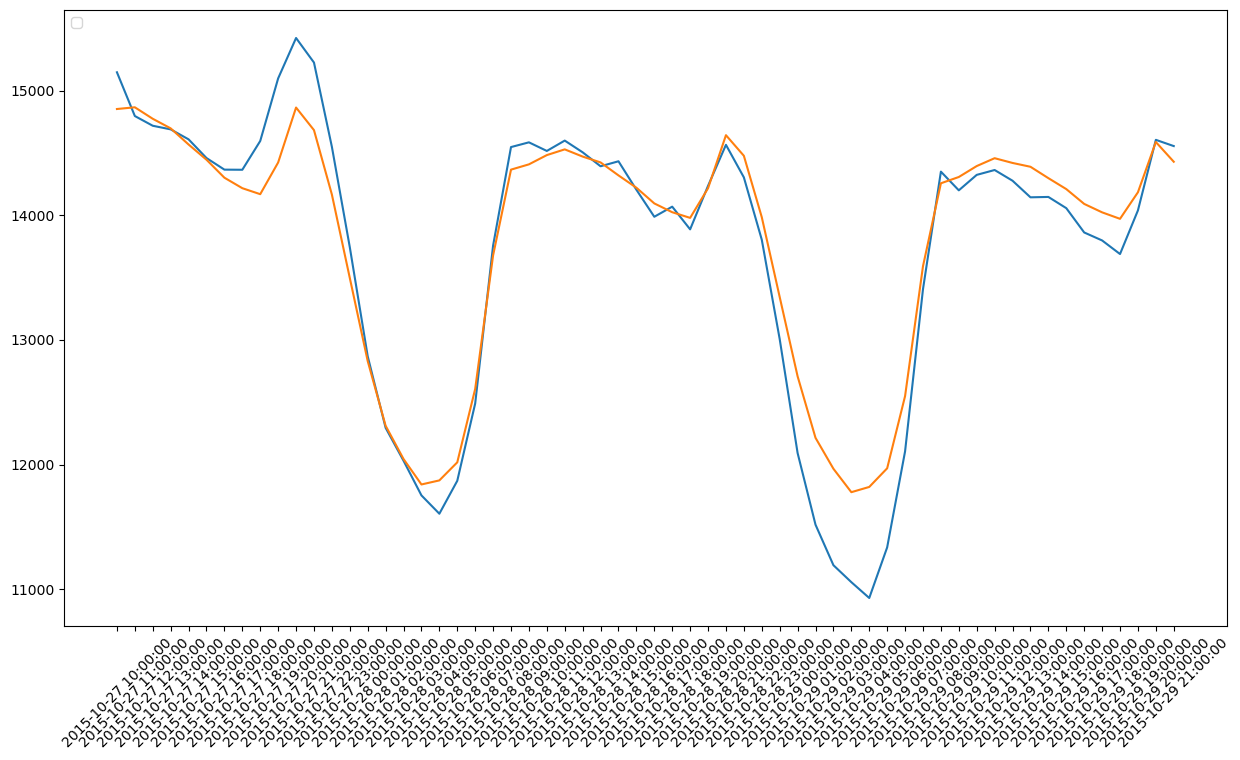

In [39]:
plt.figure(figsize=(15,8))
plt.plot(comp_table['AEP_MW'])
plt.plot(comp_table['prediction'])
plt.legend('AEP_MW','prediction',loc='upper left')
plt.xticks(rotation=45)
plt.show()

## Manual Method

In [ ]:
data_diff = train_dataset.diff()
data_diff = data_diff.dropna()
data_diff

,AEP_MW
Datetime,
2004-10-01 02:00:00,-444.0
2004-10-01 03:00:00,-243.0
2004-10-01 04:00:00,-95.0
2004-10-01 05:00:00,84.0
2004-10-01 06:00:00,599.0
...,...
2015-10-27 05:00:00,179.0
2015-10-27 06:00:00,804.0
2015-10-27 07:00:00,1449.0


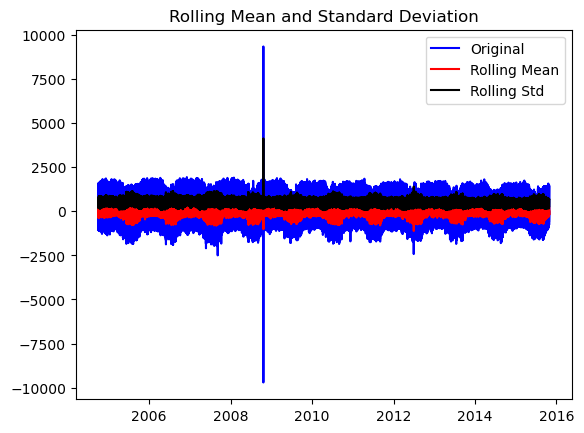

Results of dickey fuller test
Test Statistics                  -57.006653
p-value                            0.000000
No. of lags used                  67.000000
Number of observations used    96949.000000
critical value (1%)               -3.430417
critical value (5%)               -2.861570
critical value (10%)              -2.566786
dtype: float64


In [ ]:
test_stationarity(data_diff)

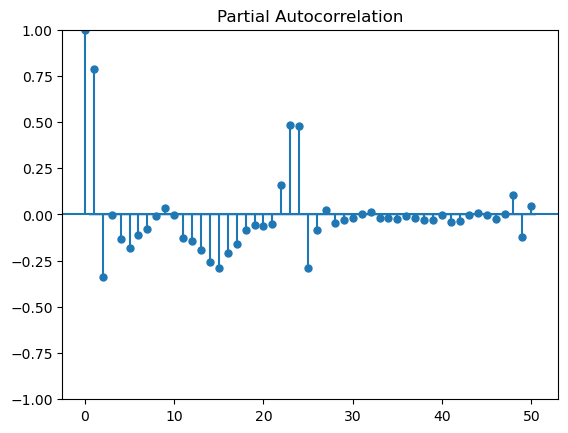

In [ ]:
plot_pacf(data_diff)
plt.show()

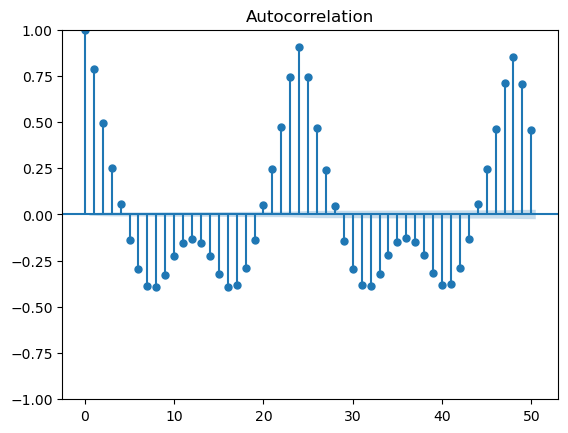

In [ ]:
plot_acf(data_diff)
plt.show()

In [ ]:
model = ARIMA(train_dataset,order=(2,1,4))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:                97018
Model:                 ARIMA(2, 1, 4)   Log Likelihood             -693171.423
Date:                Thu, 04 Jul 2024   AIC                        1386356.846
Time:                        13:53:32   BIC                        1386423.224
Sample:                             0   HQIC                       1386377.018
                              - 97018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6766      0.001   1165.920      0.000       1.674       1.679
ar.L2         -0.9415      0.001   -670.124      0.000      -0.944      -0.939
ma.L1         -0.7570      0.001   -531.530      0.0

In [ ]:
start = len(train_dataset)
end = start+60-1
pred = fitted.predict(start=start, end=end, typ='levels')
pred

97018    14599.279926
97019    14323.281508
97020    13871.282278
97021    13265.701683
97022    12675.896440
97023    12257.132329
97024    12110.292326
97025    12258.344616
97026    12644.821067
97027    13153.420675
97028    13642.310155
97029    13983.178045
97030    14094.421987
97031    13960.024096
97032    13629.953714
97033    13203.072187
97034    12798.090983
97035    12520.973201
97036    12437.619193
97037    12558.760269
97038    12840.346236
97039    13198.417212
97040    13533.673584
97041    13758.669947
97042    13820.278048
97043    13711.747170
97044    13471.777083
97045    13171.609303
97046    12894.256426
97047    12711.830136
97048    12667.083046
97049    12763.805722
97050    12968.103549
97051    13219.578453
97052    13448.874603
97053    13596.569215
97054    13628.327152
97055    13542.524857
97056    13368.765508
97057    13158.211779
97058    12968.775209
97059    12849.385314
97060    12827.558092
97061    12903.362829
97062    13051.010364
97063    1

In [ ]:
df_test = pd.read_csv('AEP_hourly_test.csv',parse_dates=['Datetime'])
#df_test.index = df_test['Datetime']
#df_test = df_test.drop('Datetime', axis=1)
df_test

,Datetime,AEP_MW
0,2015-10-27 10:00:00,15147.0
1,2015-10-27 11:00:00,14796.0
2,2015-10-27 12:00:00,14718.0
3,2015-10-27 13:00:00,14689.0
4,2015-10-27 14:00:00,14609.0
...,...,...
24250,2018-08-02 20:00:00,17673.0
24251,2018-08-02 21:00:00,17303.0
24252,2018-08-02 22:00:00,17001.0
24253,2018-08-02 23:00:00,15964.0


In [ ]:
comp_table_1 = df_test[:60]
comp_table_1.head()

,Datetime,AEP_MW
0,2015-10-27 10:00:00,15147.0
1,2015-10-27 11:00:00,14796.0
2,2015-10-27 12:00:00,14718.0
3,2015-10-27 13:00:00,14689.0
4,2015-10-27 14:00:00,14609.0


In [ ]:
predict_1 = pd.DataFrame(pred).reset_index()
predict_1.drop('index',axis=1, inplace=True)
predict_1.head()

,predicted_mean
0,14599.279926
1,14323.281508
2,13871.282278
3,13265.701683
4,12675.896440


In [ ]:
comp_table_1['prediction'] = predict_1['predicted_mean']
comp_table_1['difference'] = comp_table_1['prediction']-comp_table_1['AEP_MW']
comp_table_1

,Datetime,AEP_MW,prediction,difference
0,2015-10-27 10:00:00,15147.0,14599.279926,-547.720074
1,2015-10-27 11:00:00,14796.0,14323.281508,-472.718492
2,2015-10-27 12:00:00,14718.0,13871.282278,-846.717722
3,2015-10-27 13:00:00,14689.0,13265.701683,-1423.298317
4,2015-10-27 14:00:00,14609.0,12675.896440,-1933.103560
5,2015-10-27 15:00:00,14459.0,12257.132329,-2201.867671
6,2015-10-27 16:00:00,14366.0,12110.292326,-2255.707674
7,2015-10-27 17:00:00,14365.0,12258.344616,-2106.655384
8,2015-10-27 18:00:00,14596.0,12644.821067,-1951.178933
9,2015-10-27 19:00:00,15098.0,13153.420675,-1944.579325


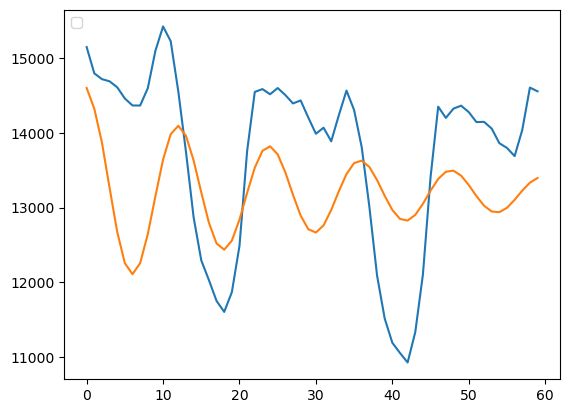

In [ ]:
plt.plot(comp_table_1['AEP_MW'])
plt.plot(comp_table_1['prediction'])
plt.legend('AEP_MW','prediction',loc='upper left')
plt.show()